In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time
import h5py
import data_processing as dp

In [75]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\其他\labels.txt
.\data\其他\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\其他\P812_M050_2_B_FoG_trials.mat
.\data\其他\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\其他\P812_M050_2_B_FoG_trial_1

In [73]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv',index_col=0)
emg_data2 = pd.read_csv('.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv',index_col=0)
emg_data3 = pd.read_csv('.\data\正常\G02_Walking_trial_1_emg.csv',index_col=0)

In [74]:
emg_data.columns

Index(['Label1', 'Label2', 'LEFT_TA', 'LEFT_TS', 'LEFT_BF', 'LEFT_RF',
       'RIGHT_TA', 'RIGHT_TS', 'RIGHT_BF', 'RIGHT_RF'],
      dtype='object')

In [3]:
#emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
#                           'LEFT_RF':emg_data.LEFT_RF.mean(),
#                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
#                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
#                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
#                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data = emg_data.dropna().reset_index()
#emg_data = emg_data[emg_data.Label1==emg_data.Label2].reset_index(drop=True)
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [126]:
emg_data2 = emg_data2.fillna({'RIGHT_TA':emg_data2.RIGHT_TA.mean()})
emg_data2 = emg_data2[emg_data2.Label1==emg_data2.Label2].reset_index(drop=True)
emg_data2.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [82]:
emg_data3 = emg_data3.fillna({'LEFT_TA':emg_data3.LEFT_TA.mean(),
                           'LEFT_TS':emg_data3.LEFT_TS.mean(),
                           'LEFT_BF':emg_data3.LEFT_BF.mean(),
                           'LEFT_RF':emg_data3.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data3.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data3.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data3.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data3.RIGHT_RF.mean()})
emg_data3 = emg_data3[emg_data3.Label1==emg_data3.Label2].reset_index(drop=True)
emg_data3.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [6]:
def scale_data(data,sc,cwt=True):
    M,N,I,J = data.shape
    result = np.zeros((M,N,I,J))
    #sc = StandardScaler()
    if cwt:
        for i in range(M):
            for j in range(J):
                cwtmatr = data[i,:,:,j]
                result[i,:,:,j] = sc.fit_transform(cwtmatr)
                
        return result
    else:
        X = data.iloc[:,3:]
        X = sc.fit_transform(X)
        data.iloc[:,3:] = X
        return data

def generate_window_slide_data(data,width = 256,stride = 64):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    sc = StandardScaler(with_mean=False)
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                x_sc = sc.fit_transform(np.array(data.iloc[i*stride:i*stride+width,3:]))
                X += [x_sc]
                #X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c),dtype=np.float32)
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr


In [35]:
files = ['P379_M050_2_OFF_A_FoG_trial_1_emg.csv',
         'P812_M050_2_B_FoG_trial_1_emg.csv',
         'P551_M050_2_A_FoG_trial_1_emg.csv']
cwtmatrs = []
y = []
for file in files:
    cwtmatr,label = dp.pipeline_cwt('.\data\\' + file,
                               scaler=False,
                               same_label=True)
    cwtmatrs += cwtmatr.tolist()
    y += label.tolist()    
cwtmatrs = np.array(cwtmatrs)
y = np.array(y)

In [38]:
cwtmatrs = np.array(cwtmatrs)
y = np.array(y)

In [7]:
sc = StandardScaler()
#sc.fit(emg_data.iloc[:,3:])
#emg_data_sc = scale_data(emg_data,sc)
#emg_data_sc2 = scale_data(emg_data3,sc)
#emg_data_scf.iloc[:,8].plot()
cwtmatr_sc=scale_data(cwtmatr,sc)

In [53]:
width = 256
stride = 64
widths_scale = 32
#x,y = generate_window_slide_data(emg_data,width,stride)
#x2,y2 = generate_window_slide_data(emg_data3,width,stride)

In [81]:
pd.Series(y).value_counts()

0    218
2    131
3      7
1      4
dtype: int64

In [3]:
file = './processed data/cwt_W256_S64_WS32_allPa_sameLabel.hdf5'
with h5py.File(file,'r') as f:
    cwtmatr = f['feature'][...]
    y = f['label'][...]
cwtmatr.shape

(16106, 32, 256, 8)

In [ ]:
path = './processed data/P812_trial_1_W256_S64_WS32_CWT.hdf5'
with h5py.File(path,'r') as f:
    cwtmatr = f['cwt_data'][...]
    y = f['label2'][...]

In [19]:
ind = ((y==1) | (y==2) | (y==6))

In [58]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale,'mexh')
#cwtmatr2 = generate_CWT_feature(x2,widths_scale,'mexh')
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 69.849566


In [61]:
#cwtmatr=StandardScaler(cwtmatr)
#cwtmatr_sc = scale_data(cwtmatr,sc)
cwtmatr_sc.max()

5.352044387867127

In [ ]:
pywt.wavelist(kind='continuous')

In [ ]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

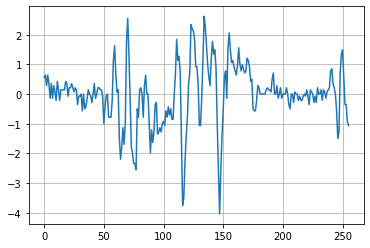

In [55]:
plt.plot(x[110,:,4])
plt.grid(True)

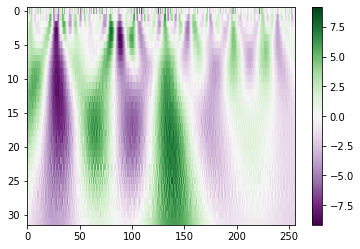

0


In [5]:
temp = 10
channel = 1
plt.imshow(cwtmatr[temp,:,:,channel], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,channel]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,channel]).max())
plt.colorbar()
plt.show()
print(y[temp])

In [93]:
#label = y[ind]
#label[label==2]=1
y.shape

(44530,)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras import callbacks, Model, models
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

In [3]:
def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.5,1,1.5],
    #              [1,0,1,1],
    #              [5,10,0,5],
    #              [1.,1.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,1.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

In [4]:
#ind = ((y[:20000]==1) | (y[:20000]==2) | (y[:20000]==3) | (y[:20000]==4) | (y[:20000]==6))
#y_02 = y[:20000]
#ind = ((y==1) | (y==2) | (y==3) | (y==4) | (y==6))
file = './processed data/cwt_W256_S64_Wc16_mexh_sc_split.hdf5'
with h5py.File(file,'r') as f:
    cwtmatr = f['features']
    y = f['labels'][...]
    cwtmatr2 = f['features2']
    y2 = f['labels2'][...]
    ind1 = ((y==1) | (y==2) | (y==6))
    ind = np.where(ind1==True)
    #print(ind)
    oc = OneHotEncoder()
    #y_02 = y.copy()
    y_02 = oc.fit_transform(y[ind1,np.newaxis]).toarray()
    #y_02[ind]=1
    ind2 = ((y2==1) | (y2==2) | (y2==6))
    ind22 = np.where(ind2==True)
    X2 = cwtmatr2[ind22]
    Y2 = oc.transform(y2[ind2,np.newaxis]).toarray()
    X_full,X_test,y_full,y_test = train_test_split(cwtmatr[ind],y_02,test_size = 0.2,shuffle = True,random_state=123)
    #X_full,X_test,y_full,y_test= train_test_split(X_full1,y_full1,test_size = 0.2,shuffle = True,random_state=123)
    #X_train,X_valid,y_train,y_valid= train_test_split(X_full,y_full,test_size = 0.2,random_state=555)

In [103]:
pd.Series(y).value_counts()
#X_test.shape

0    9631
2    9152
6    3992
1    3645
3      93
dtype: int64

In [5]:
input_ = layers.Input(shape=X_full.shape[1:])
#bn = layers.BatchNormalization()(input_)
max_pool = layers.MaxPooling2D((2,2))(input_)
#bn = layers.BatchNormalization()(max_pool)
cnn1 = layers.Conv2D(16,3,strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(max_pool)
cnn1 = layers.Activation('relu')(cnn1)
cnn1 = layers.Dropout(0.2)(cnn1)
#cnn1 = layers.BatchNormalization()(cnn1)
cnn1 = layers.MaxPooling2D((2,2))(cnn1)

cnn2 = layers.Conv2D(32,3,strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn1)
cnn2 = layers.Activation('relu')(cnn2)
cnn2 = layers.Dropout(0.2)(cnn2)
#cnn2 = layers.BatchNormalization()(cnn2)
cnn2 = layers.MaxPooling2D(2)(cnn2)

cnn3 = layers.Conv2D(64,3,strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn2)
cnn3 = layers.Activation('relu')(cnn3)
cnn3 = layers.Dropout(0.2)(cnn3)
#cnn3 = layers.BatchNormalization()(cnn3)
cnn3 = layers.MaxPooling2D(2)(cnn3)

cnn4 = layers.Conv2D(128,3,strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(cnn3)
cnn4 = layers.Activation('relu')(cnn4)
cnn4 = layers.Dropout(0.2)(cnn4)
cnn4 = layers.BatchNormalization()(cnn4)
cnn4 = layers.MaxPooling2D(2)(cnn4)
flatten = layers.Flatten()(cnn4)

#dropout = layers.Dropout(0.2)(flatten)
#dense1 = layers.Dense(256,activation = 'relu')(dropout)
#dense1 = layers.Dropout(0.2)(dense1)
#dense2 = layers.Dense(128,activation = 'relu')(dense1)
#dropout2 = layers.Dropout(0.2)(layer2)
output = layers.Dense(3,activation = 'softmax')(flatten)
model = keras.Model(inputs=[input_],outputs=[output])

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_4/MaxPool' (op: 'MaxPool') with input shapes: [?,1,16,128].

In [ ]:
#ind = ((y==0) | (y==2))
#bce = CategoricalCrossentropy()
model.compile(loss = 'categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])
#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(K.eval(y)[ind,tf.newaxis]).toarray()

In [ ]:
cw = None#{0:2,1:1,2:10,3:2}
early_stopping = callbacks.EarlyStopping(patience = 10,monitor = 'val_accuracy', restore_best_weights=True)

In [ ]:
history = model.fit(X_full,y_full,validation_data=[X_test,y_test],
                    epochs=100,batch_size=32,
                    class_weight=cw,
                    callbacks=[early_stopping]
                   )

In [24]:
model.evaluate(X2,Y2)

2143/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.063381341626938, 0.69668686]

In [25]:
y_pred=model.predict(X2)
confusion_matrix(np.argmax(Y2,axis=1),np.argmax(y_pred,axis=1))

array([[147, 205, 124],
       [ 90, 927,  60],
       [ 38, 133, 419]], dtype=int64)

In [36]:
#y_pred = model.predict(X_test)

#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(y_full[:,np.newaxis]).toarray()
#precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])
#y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
#y_pred = y_pred+1
#y_pred = oh_ec.fit_transform(y_pred[:,np.newaxis]).toarray()
#y_pred = oc.inverse_transform(y_pred)
#y_train_i = oc.inverse_transform(y_test)

y_pred_t=model.predict(X_test)
test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
#y_pred_v=model.predict(x_valid)
#valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
y_pred_ta=model.predict(X_full)
train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
print('test:%f'%test)
#print('valid:%f'%valid)
print('train:%f'%train)
print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
#print('valid: \n',metrics.confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))

test:0.922535
train:0.989284
train: 
 [[1488    6    9]
 [  15 3368   42]
 [   1    0 1883]]
test: 
 [[338  19  34]
 [ 25 779  42]
 [  8   4 455]]


In [38]:
file = 'G08_FoG_1_trial_1_emg.csv'
feature,label = dp.pipeline_cwt('./data/'+file,width = 256, 
                                           stride=32,
                                           scaler=True,
                                           norm=False,
                                           width_c=32,
                                       same_label=True,
                                           dropna=True)
ind1 = ((label==1) | (label==2) | (label==6))
y_pred=model.predict(feature[ind1])
print(accuracy_score(label[ind1],oc.inverse_transform(y_pred>0.5)))
confusion_matrix(label[ind1],oc.inverse_transform(y_pred>0.5))

0.42793889749833963


array([[  22,  958,  122],
       [  21, 1405,   96],
       [  44, 1343,  506]], dtype=int64)

In [21]:
#plt.plot(recall,precision)
confusion_matrix(y_train_i,y_pred)

array([[ 425,   38,    0,    6],
       [  51, 1022,    0,   10],
       [   0,    1,    6,    0],
       [   9,   12,    0,  562]], dtype=int64)

In [84]:
y_pred

array([[6.0590548e-03, 9.9391526e-01, 2.5762538e-05],
       [1.0573975e-08, 1.0000000e+00, 3.8397259e-09],
       [1.6229848e-10, 1.0000000e+00, 1.7472540e-13],
       ...,
       [9.2019298e-16, 1.0000000e+00, 1.2263473e-16],
       [3.9972323e-09, 1.0000000e+00, 1.0092542e-09],
       [1.5464315e-10, 1.0000000e+00, 3.6735908e-09]], dtype=float32)

TypeError: Length of y must be number of rows in z.

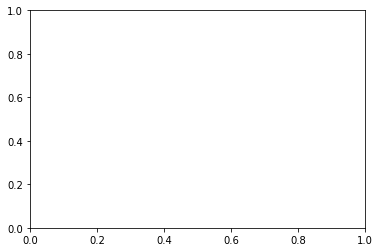

In [31]:
t = np.arange(0,256)
f=np.array([500.   , 484.375, 468.75 , 453.125, 437.5  , 421.875, 406.25 ,
       390.625, 375.   , 359.375, 343.75 , 328.125, 312.5  , 296.875,
       281.25 , 265.625, 250.   , 234.375, 218.75 , 203.125, 187.5  ,
       171.875, 156.25 , 140.625, 125.   , 109.375,  93.75 ,  78.125,
        62.5  ,  46.875,  31.25,32 ])
plt.contourf(t, f, abs(X_full[50,:,:,7]))

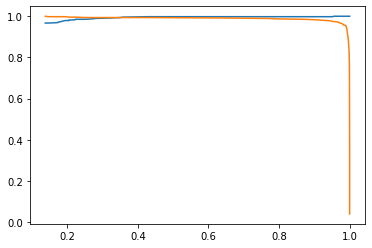

In [166]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [95]:
#model = load_model('./model/Mexh_W256_S32_WS32.h5')
ind = ((y2==1) | (y2==2) | (y2==3))
y_02=y2
y_02[ind]=1
model.evaluate(cwtmatr,y[25000:35000])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.8236013696538722, 0.7228]

In [78]:
(model.predict(cwtmatr2).argmax(axis=1)==y_02).sum()

284

In [87]:
cwtmatr.shape

(20000, 32, 256, 8)

array([[ 651,    7],
       [   9, 1167]], dtype=int64)

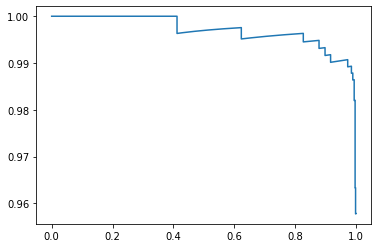

In [53]:
y_pred = model.predict(cwtmatr[ind])
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(y_02[:,np.newaxis]).toarray()
precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])
plt.plot(recall,precision)
confusion_matrix(y_02,np.where(y_pred<0.5,1,0)[:,0])

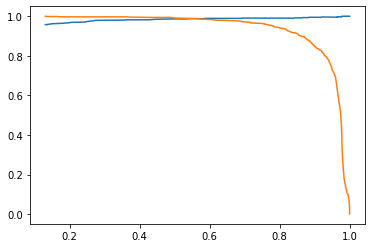

In [54]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [232]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 256, 8)]      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 256, 8)        32        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 128)      25728     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 64, 128)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 32, 64)         204864    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 16, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0   

(0, 1)

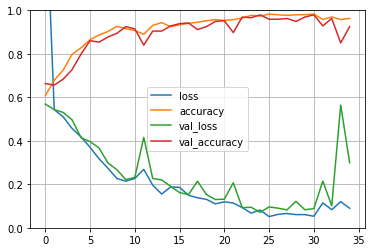

In [22]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)

In [39]:
model.save('./model/Mexh_W%d_S%d_WS%d.h5'%(width,stride,widths_scale))

# cnn2

In [88]:
path = './processed data/data_set_after_window_W256_S64_sameLabel_nm_filt_split.hdf5'
with h5py.File(path,'r') as f:
    x = f['data'][...]
    y = f['label1'][...]
    x2 = f['data2'][...]
    y2 = f['label2'][...]

In [68]:
x = np.reshape(x,(-1,256,8,1))
x2 = np.reshape(x2,(-1,256,8,1))

In [3]:
y.shape

(16106,)

In [84]:
def train_model(model,feature,y,binary=True,file=None):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y.copy()
        #ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==1)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}
    x_full,x_test,y_full,y_test = train_test_split(np.array(feature)[ind,:],y_01,
                                                   test_size=0.2,
                                                   random_state=123,
                                                   shuffle=True)
    x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,
                                                       test_size=0.25,
                                                       random_state=555,
                                                       shuffle=True)
    
    #sm = BorderlineSMOTE(random_state=50,kind='borderline-2')
    #sm = SMOTE(random_state=50)
    #print(y_full.shape)
    #x_full,y_full = sm.fit_resample(x_full,y_full)
    #print(y_full_n.shape)
    #sc = StandardScaler(with_mean=True)
    #sc = MinMaxScaler()
    #x_train = sc.fit_transform(x_full)
    #pca = PCA(n_components=100)
    #x_train = pca.fit_transform(x_train)
    #x_valid = sc.transform(x_valid)
    #x_test = sc.transform(x_test)
    #x_test = pca.transform(x_test)
    x_train = x_full
    
    early_stopping = callbacks.EarlyStopping(patience = 10,
                                             monitor = 'val_loss', 
                                             restore_best_weights=True)
    history = model.fit(x_train,y_full,validation_data=[x_test,y_test],
                        epochs=300,batch_size=32,class_weight=cw,
                        #callbacks=[early_stopping],
                        shuffle=True)
    
    if binary:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #test = accuracy_score(y_test,y_pred_t>0.5)
        
        #y_pred_v=model.predict(x_valid)
        #valid = accuracy_score(y_valid,np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
        #train = accuracy_score(y_full,y_pred_ta>0.5)
        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
        
        #print('train: \n',metrics.confusion_matrix(y_full,y_pred_ta>0.5))
        #print('test: \n',metrics.confusion_matrix(y_test,y_pred_t>0.5))

    else:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #y_pred_v=model.predict(x_valid)
        #valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
    print('test:%f'%test)
    #print('valid:%f'%valid)
    print('train:%f'%train)
    if file != None:
        model.save_model(file)
    return train,test

def test_model(model,feature,y,binary=True):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        #ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y[ind].copy()
        ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==1)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}

    #print(y_01)
    #feature=sc.transform(feature[ind])
    #feature=pca.transform(feature)
    y_pred=model.predict(feature[ind])
    test = accuracy_score(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1))
    #test = metrics.accuracy_score(y_01,y_pred>0.5)
    
    print('acc:%f'%test)
    print(confusion_matrix(np.argmax(y_01,axis=1),np.argmax(y_pred,axis=1)))
    #print(metrics.confusion_matrix(y_01,y_pred>0.5))
    return test

def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.5,1,1.5],
    #              [1,0,1,1],
    #              [5,10,0,5],
    #              [1.,1.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,1.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

In [83]:
model = models.Sequential()
#input_ = layers.Input(shape=x.shape[1:])
model.add(keras.layers.InputLayer(input_shape=x.shape[1:]))
#model.add(layers.BatchNormalization())
model.add(layers.Conv2D(8,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(8,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(16,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(2))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(32,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(32,(3,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(2))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(256,activation = 'relu'))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(128,activation = 'relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 8, 8)         152       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 8, 8)         1160      
_________________________________________________________________
activation_8 (Activation)    (None, 256, 8, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 4, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 4, 16)        2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 4, 16)        4624      
_________________________________________________________________
activation_9 (Activation)    (None, 128, 4, 16)       

In [79]:
import discriminator
import imp
imp.reload(discriminator)

<module 'discriminator' from 'E:\\Document\\jupyter\\Master Thesis\\discriminator.py'>

In [85]:
args = {'num_steps': 256,
        'channels': 8,
        'conv_activation': 'relu',
        'dropout_rate': 0.2,
        'wavelet_mother': 'db7',
        'wavelet_levels': 2,
        'wavelet_trainable': True,
        'use_mini_batch': False,
        'sliding_window': 10,
        'activation_function': 'tanh',
        'moving_avg_window': 100,
        }

In [86]:
cric = discriminator.Discriminator(args,training=True)
cric.model.compile(loss = 'categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])

Tensor("low_pass_0_13/Identity:0", shape=(None, 128, 1), dtype=float32)
Tensor("low_pass_1_13/Identity:0", shape=(None, 128, 1), dtype=float32)
Critic model:
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 256, 8)]     0                                            
__________________________________________________________________________________________________
envelope (Lambda)               (None, 256, 8)       0           input_23[0][0]                   
__________________________________________________________________________________________________
flatten_82 (Flatten)            (None, 2048)         0           input_23[0][0]                   
__________________________________________________________________________________________________
flatten_85 (Flatten)            

In [89]:
train_model(cric.model,x,y,binary=False)

Train on 6812 samples, validate on 1704 samples
Epoch 1/300
6812/6812 [==============================] - 69s 10ms/sample - loss: 1.0511 - accuracy: 0.5615 - val_loss: 0.7474 - val_accuracy: 0.6819
Epoch 2/300
6812/6812 [==============================] - 44s 6ms/sample - loss: 0.8163 - accuracy: 0.6718 - val_loss: 0.6790 - val_accuracy: 0.7119
Epoch 3/300
6812/6812 [==============================] - 47s 7ms/sample - loss: 0.7410 - accuracy: 0.7026 - val_loss: 0.6270 - val_accuracy: 0.7242
Epoch 4/300
6812/6812 [==============================] - 38s 6ms/sample - loss: 0.6562 - accuracy: 0.7306 - val_loss: 0.6268 - val_accuracy: 0.7347
Epoch 5/300
6812/6812 [==============================] - 40s 6ms/sample - loss: 0.5913 - accuracy: 0.7619 - val_loss: 0.5330 - val_accuracy: 0.7723
Epoch 6/300
6812/6812 [==============================] - 38s 6ms/sample - loss: 0.5434 - accuracy: 0.7801 - val_loss: 0.5248 - val_accuracy: 0.7658
Epoch 7/300
6812/6812 [==============================] - 40s 6m

6812/6812 [==============================] - 40s 6ms/sample - loss: 0.0711 - accuracy: 0.9750 - val_loss: 0.2273 - val_accuracy: 0.9261
Epoch 111/300
6812/6812 [==============================] - 48s 7ms/sample - loss: 0.0716 - accuracy: 0.9736 - val_loss: 0.2277 - val_accuracy: 0.9319
Epoch 112/300
6812/6812 [==============================] - 42s 6ms/sample - loss: 0.0683 - accuracy: 0.9746 - val_loss: 0.2436 - val_accuracy: 0.9278
Epoch 113/300
6812/6812 [==============================] - 41s 6ms/sample - loss: 0.0637 - accuracy: 0.9772 - val_loss: 0.2399 - val_accuracy: 0.9278
Epoch 114/300
6812/6812 [==============================] - 43s 6ms/sample - loss: 0.0746 - accuracy: 0.9759 - val_loss: 0.2484 - val_accuracy: 0.9272
Epoch 115/300
6812/6812 [==============================] - 41s 6ms/sample - loss: 0.0637 - accuracy: 0.9745 - val_loss: 0.2276 - val_accuracy: 0.9255
Epoch 116/300
6812/6812 [==============================] - 40s 6ms/sample - loss: 0.0624 - accuracy: 0.9783 - val_

Epoch 165/300
6812/6812 [==============================] - 35s 5ms/sample - loss: 0.0506 - accuracy: 0.9849 - val_loss: 0.2319 - val_accuracy: 0.9302
Epoch 166/300
6812/6812 [==============================] - 36s 5ms/sample - loss: 0.0535 - accuracy: 0.9812 - val_loss: 0.2333 - val_accuracy: 0.9308
Epoch 167/300
6812/6812 [==============================] - 35s 5ms/sample - loss: 0.0614 - accuracy: 0.9774 - val_loss: 0.2650 - val_accuracy: 0.9202
Epoch 168/300
6812/6812 [==============================] - 35s 5ms/sample - loss: 0.0513 - accuracy: 0.9822 - val_loss: 0.2555 - val_accuracy: 0.9243
Epoch 169/300
6812/6812 [==============================] - 36s 5ms/sample - loss: 0.0578 - accuracy: 0.9806 - val_loss: 0.2440 - val_accuracy: 0.9302
Epoch 170/300
6812/6812 [==============================] - 41s 6ms/sample - loss: 0.0542 - accuracy: 0.9808 - val_loss: 0.2205 - val_accuracy: 0.9272
Epoch 171/300
6812/6812 [==============================] - 37s 5ms/sample - loss: 0.0487 - accuracy:

Epoch 274/300
6812/6812 [==============================] - 35s 5ms/sample - loss: 0.0470 - accuracy: 0.9833 - val_loss: 0.2037 - val_accuracy: 0.9442
Epoch 275/300
6812/6812 [==============================] - 34s 5ms/sample - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.2168 - val_accuracy: 0.9360
Epoch 276/300
6812/6812 [==============================] - 40s 6ms/sample - loss: 0.0454 - accuracy: 0.9841 - val_loss: 0.2219 - val_accuracy: 0.9396
Epoch 277/300
6812/6812 [==============================] - 35s 5ms/sample - loss: 0.0391 - accuracy: 0.9872 - val_loss: 0.1934 - val_accuracy: 0.9478
Epoch 278/300
6812/6812 [==============================] - 34s 5ms/sample - loss: 0.0327 - accuracy: 0.9883 - val_loss: 0.2011 - val_accuracy: 0.9466
Epoch 279/300
6812/6812 [==============================] - 36s 5ms/sample - loss: 0.0380 - accuracy: 0.9861 - val_loss: 0.2230 - val_accuracy: 0.9390
Epoch 280/300
6812/6812 [==============================] - 34s 5ms/sample - loss: 0.0354 - accuracy:

(1.0, 0.9401408450704225)

In [91]:
test_model(cric.model,x2,y2,False)

acc:0.693420
[[182 191 103]
 [138 879  60]
 [ 61 104 425]]


0.6934204386374242

In [57]:
y2.shape

(3244,)

In [83]:
np.concatenate([y[:14000],y[20000:25000]]).shape

(19000,)

In [14]:
x[20000:25000].shape

(0, 256, 8)

In [156]:
low_pass, high_pass  = pywt.Wavelet('db7').filter_bank[:2]

In [162]:
np.array([low_pass]*8).shape

(8, 14)